# Exploratory Data Analysis — Video Game Sales with Ratings

**Dataset**: [rush4ratio / Video Game Sales with Ratings]  
**Objetivo**: preparar datos limpios, visualizar patrones clave y extraer conclusiones ejecutivas para el CEO.


In [30]:
# Librerías a usar
import os
import sys
import math
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)

Versions -> pandas: 2.3.2 | numpy: 2.3.2


## 1) Carga de datos

In [31]:
from pathlib import Path

df = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")

# Vista rápida
# print("✅ Dataset cargado correctamente con forma:", df.shape)

if df is None:
    print("❗ Noe se encontró el CSV. Copia el archivo en /mnt/data y re-ejecuta esta celda.")
else:
    print("✅ Archivoo detectado:")

✅ Archivoo detectado:


## 2) Exploración inicial

In [32]:
if 'df' in globals():
    # Nombres y tipos
    display(pd.DataFrame({
        "column": df.columns,
        "dtype": [df[c].dtype for c in df.columns],
        "n_null": [df[c].isna().sum() for c in df.columns],
        "n_unique": [df[c].nunique(dropna=True) for c in df.columns]
    }))

    # Vista rápida de estadísticas numéricas
    display(df.describe(include=[np.number]).T)

    # Vista de categóricas
    cat_cols = [c for c in df.columns if df[c].dtype == "object"]
    display(df[cat_cols].describe().T)

,column,dtype,n_null,n_unique
0,Name,object,2,11562
1,Platform,object,0,31
2,Year_of_Release,float64,269,39
3,Genre,object,2,12
4,Publisher,object,54,581
5,NA_Sales,float64,0,402
6,EU_Sales,float64,0,307
7,JP_Sales,float64,0,244
8,Other_Sales,float64,0,155
9,Global_Sales,float64,0,629


,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16450.0,2006.487356,5.878995,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16719.0,0.263330,0.813514,0.00,0.00,0.08,0.24,41.36
EU_Sales,16719.0,0.145025,0.503283,0.00,0.00,0.02,0.11,28.96
JP_Sales,16719.0,0.077602,0.308818,0.00,0.00,0.00,0.04,10.22
Other_Sales,16719.0,0.047332,0.186710,0.00,0.00,0.01,0.03,10.57
Global_Sales,16719.0,0.533543,1.547935,0.01,0.06,0.17,0.47,82.53
Critic_Score,8137.0,68.967679,13.938165,13.00,60.00,71.00,79.00,98.00
Critic_Count,8137.0,26.360821,18.980495,3.00,12.00,21.00,36.00,113.00
User_Count,7590.0,162.229908,561.282326,4.00,10.00,24.00,81.00,10665.00


,count,unique,top,freq
Name,16717,11562,Need for Speed: Most Wanted,12
Platform,16719,31,PS2,2161
Genre,16717,12,Action,3370
Publisher,16665,581,Electronic Arts,1356
User_Score,10015,96,tbd,2425
Developer,10096,1696,Ubisoft,204
Rating,9950,8,E,3991


## 3) Limpieza y preprocesado

In [33]:
# === Enhanced cleaning & preprocessing (merged from professor's notebook) ===
# Start from original df loaded previously
df_clean = df.copy()

# 1) Standardize column names to snake_case
df_clean.columns = (
    df_clean.columns
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9A-Za-z_]", "", regex=True)
    .str.lower()
)

# 2) Rename common columns (if present)
rename_map = {
    "name": "title",
    "year_of_release": "year",
    "na_sales": "na_sales",
    "eu_sales": "eu_sales",
    "jp_sales": "jp_sales",
    "other_sales": "other_sales",
    "global_sales": "global_sales",
    "critic_score": "critic_score",
    "critic_count": "critic_count",
    "user_score": "user_score",
    "user_count": "user_count",
    "rating": "esrb_rating",
    "platform": "platform",
    "genre": "genre",
    "publisher": "publisher",
    "developer": "developer"
}
df_clean = df_clean.rename(columns={k:v for k,v in rename_map.items() if k in df_clean.columns})

# 3) Trim whitespace in object columns and unify case for categorical columns
for c in df_clean.select_dtypes(include=['object']).columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# 4) Year: coerce to integer where possible and filter unrealistic years
if "year" in df_clean.columns:
    def coerce_year(x):
        try:
            # handle floats like 2006.0 and strings
            y = int(float(x))
            if 1950 <= y <= 2030:
                return y
            return pd.NA
        except:
            return pd.NA
    df_clean["year"] = df_clean["year"].apply(coerce_year)

# 5) Normalize platform names (common mappings)
if "platform" in df_clean.columns:
    platform_map = {
        "PlayStation 4": "PS4",
        "PLAYSTATION 4": "PS4",
        "PlayStation 3": "PS3",
        "PLAYSTATION 3": "PS3",
        "PlayStation 2": "PS2",
        "PLAYSTATION 2": "PS2",
        "PlayStation": "PS1",
        "XBOX 360": "X360",
        "Xbox 360": "X360",
        "Xbox One": "XOne",
        "NINTENDO DS": "DS",
        "Nintendo DS": "DS",
        "Nintendo 3DS": "3DS",
        "Nintendo Switch": "NS"
    }
    df_clean["platform"] = df_clean["platform"].replace(platform_map)
    # uppercase and strip
    df_clean["platform"] = df_clean["platform"].astype(str).str.upper().str.replace(r"\s+","",regex=True)

# 6) Scores: handle 'tbd' or non-numeric user_score and critic_score, convert scales if needed
import numpy as np
if "user_score" in df_clean.columns:
    # Some datasets use 'tbd' or 'TBD' as text; convert to NaN
    df_clean["user_score"] = df_clean["user_score"].replace(["tbd","TBD","Tbd"], pd.NA)
    # convert to numeric if possible
    def parse_user_score(x):
        try:
            v = float(x)
            # many user_score are in 0-10 range, others in 0-100; keep as-is but detect >10 and scale down
            if v > 10:
                return v / 10.0
            return v
        except:
            return pd.NA
    df_clean["user_score"] = df_clean["user_score"].apply(parse_user_score)

if "critic_score" in df_clean.columns:
    df_clean["critic_score"] = pd.to_numeric(df_clean["critic_score"], errors="coerce")
    # Some critic scores might be 0-100; scale to 0-10 if max>10
    if df_clean["critic_score"].max(skipna=True) > 10:
        df_clean["critic_score"] = df_clean["critic_score"] / 10.0

# 7) Sales columns: ensure numeric and non-negative
for col in ["na_sales","eu_sales","jp_sales","other_sales","global_sales"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
        # negative sales make no sense; set negatives to NaN
        df_clean.loc[df_clean[col] < 0, col] = pd.NA

# 8) Fill or drop missing critical values
# We will drop rows where title or global_sales is missing because they are essential for analysis
if "title" in df_clean.columns and "global_sales" in df_clean.columns:
    before = len(df_clean)
    df_clean = df_clean[df_clean["title"].notna() & df_clean["global_sales"].notna()]
    dropped_essential = before - len(df_clean)
else:
    dropped_essential = 0

# 9) Handle duplicates: keep the row with the highest global_sales for the same (title, platform, year) if duplicates exist
key_cols = [c for c in ["title","platform","year"] if c in df_clean.columns]
if key_cols:
    df_clean = df_clean.sort_values(by="global_sales", ascending=False)
    df_clean = df_clean.drop_duplicates(subset=key_cols, keep="first")

# 10) Create derived columns useful for analysis
# e.g., total score average of critic and user (if available)
if set(["critic_score","user_score"]).issubset(df_clean.columns):
    df_clean["avg_score"] = df_clean[["critic_score","user_score"]].mean(axis=1, skipna=True)

# 11) Reset index
df_clean = df_clean.reset_index(drop=True)

print(f"Enhanced cleaning completed. Rows after essential drops: {len(df_clean)}. Duplicates handled. Essential rows dropped: {dropped_essential}")

Enhanced cleaning completed. Rows after essential drops: 16717. Duplicates handled. Essential rows dropped: 0


## 4) Análisis exploratorio (EDA)

year
1980     9
1981    46
1982    36
1983    17
1984    14
Name: count, dtype: int64

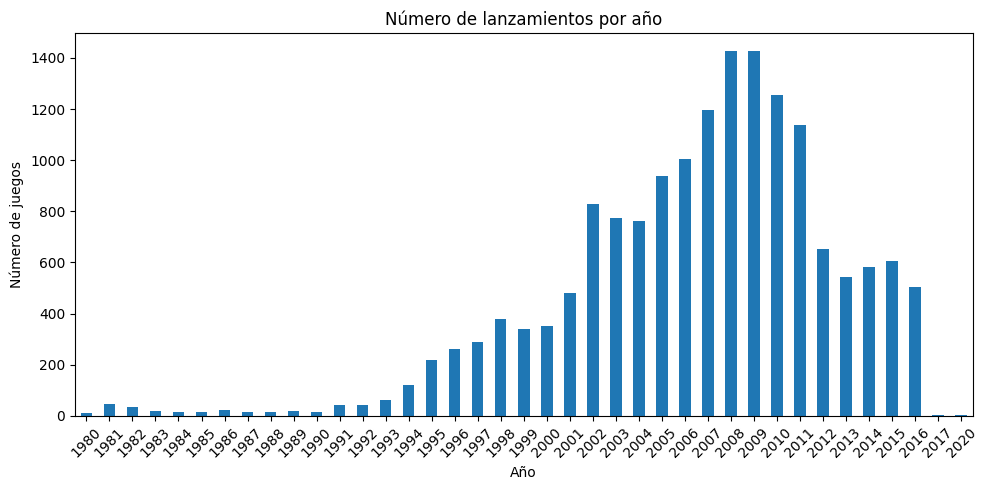

In [34]:
if 'df_clean' in globals():
    # Distribución por año
    if "year" in df_clean.columns:
        year_counts = df_clean['year'].dropna().astype(int).value_counts().sort_index()
        display(year_counts.head())

        plt.figure(figsize=(10,5))
        year_counts.plot(kind='bar')
        plt.title("Número de lanzamientos por año")
        plt.xlabel("Año")
        plt.ylabel("Número de juegos")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

platform
PS2     1255.64
X360     971.63
PS3      939.42
WII      908.13
DS       807.10
PS       730.68
GBA      318.50
PS4      314.23
PSP      294.30
PC       260.30
3DS      259.09
XB       258.26
GB       255.45
NES      251.07
N64      218.88
Name: global_sales, dtype: float64

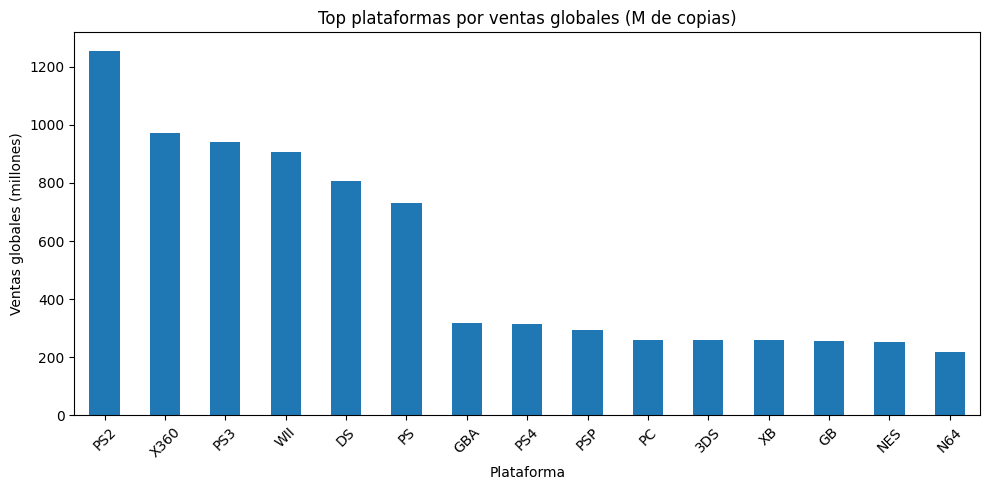

In [35]:
if 'df_clean' in globals() and set(["platform","global_sales"]).issubset(df_clean.columns):
    top_platforms = (
        df_clean.groupby("platform")["global_sales"]
        .sum()
        .sort_values(ascending=False)
        .head(15)
    )
    display(top_platforms)

    plt.figure(figsize=(10,5))
    top_platforms.plot(kind='bar')
    plt.title("Top plataformas por ventas globales (M de copias)")
    plt.xlabel("Plataforma")
    plt.ylabel("Ventas globales (millones)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

genre
Action          1745.27
Sports          1331.99
Shooter         1052.94
Role-Playing     934.40
Platform         828.08
Misc             803.18
Racing           728.90
Fighting         447.48
Simulation       390.42
Puzzle           243.02
Adventure        237.69
Strategy         174.50
nan                2.39
Name: global_sales, dtype: float64

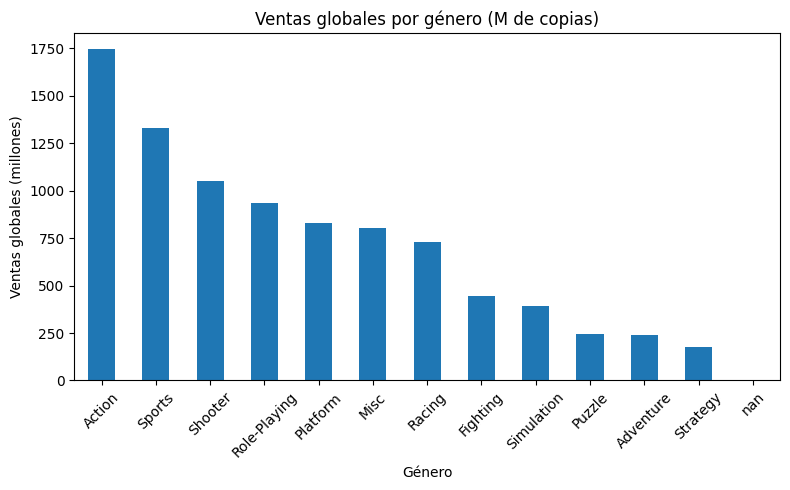

In [36]:
if 'df_clean' in globals() and set(["genre","global_sales"]).issubset(df_clean.columns):
    genre_sales = (
        df_clean.groupby("genre")["global_sales"]
        .sum()
        .sort_values(ascending=False)
    )
    display(genre_sales)

    plt.figure(figsize=(8,5))
    genre_sales.plot(kind='bar')
    plt.title("Ventas globales por género (M de copias)")
    plt.xlabel("Género")
    plt.ylabel("Ventas globales (millones)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

publisher
Nintendo                                  1788.81
Electronic Arts                           1116.95
Activision                                 731.16
Sony Computer Entertainment                606.48
Ubisoft                                    471.61
Take-Two Interactive                       403.82
THQ                                        338.44
Konami Digital Entertainment               282.39
Sega                                       270.35
Namco Bandai Games                         254.62
Microsoft Game Studios                     248.32
Capcom                                     200.02
Atari                                      156.83
Warner Bros. Interactive Entertainment     151.79
Square Enix                                145.34
Name: global_sales, dtype: float64

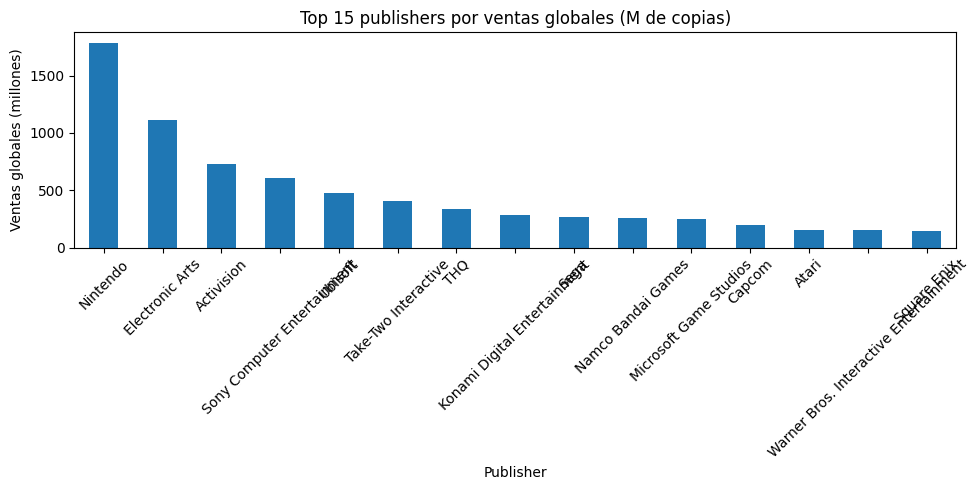

In [37]:
if 'df_clean' in globals() and set(["publisher","global_sales"]).issubset(df_clean.columns):
    top_publishers = (
        df_clean.groupby("publisher")["global_sales"]
        .sum()
        .sort_values(ascending=False)
        .head(15)
    )
    display(top_publishers)

    plt.figure(figsize=(10,5))
    top_publishers.plot(kind='bar')
    plt.title("Top 15 publishers por ventas globales (M de copias)")
    plt.xlabel("Publisher")
    plt.ylabel("Ventas globales (millones)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_count
na_sales,1.000000,0.765334,0.449594,0.638651,0.941010,0.240821,0.295406,0.246426
eu_sales,0.765334,1.000000,0.435065,0.722793,0.901238,0.220805,0.277527,0.283357
jp_sales,0.449594,0.435065,1.000000,0.291092,0.612298,0.152629,0.180214,0.075635
other_sales,0.638651,0.722793,0.291092,1.000000,0.749240,0.198603,0.251633,0.238979
global_sales,0.941010,0.901238,0.612298,0.749240,1.000000,0.245534,0.303564,0.265009
critic_score,0.240821,0.220805,0.152629,0.198603,0.245534,1.000000,0.425560,0.264409
critic_count,0.295406,0.277527,0.180214,0.251633,0.303564,0.425560,1.000000,0.362331
user_count,0.246426,0.283357,0.075635,0.238979,0.265009,0.264409,0.362331,1.000000


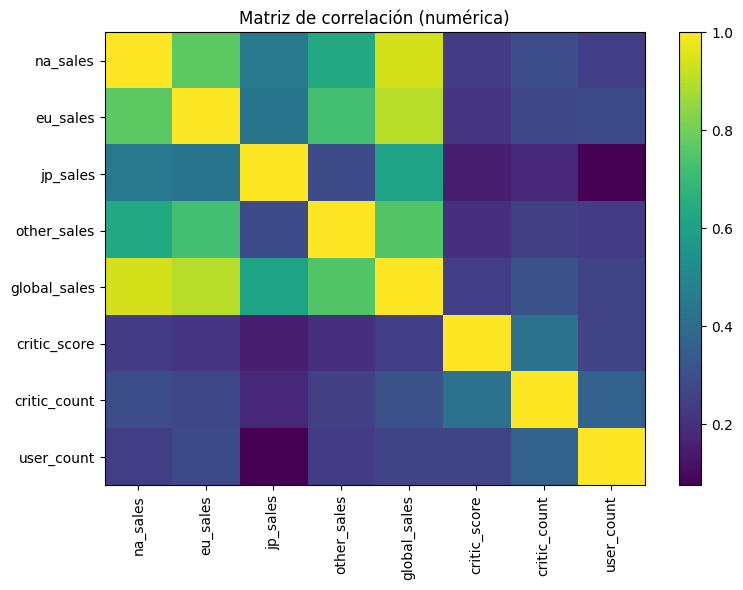

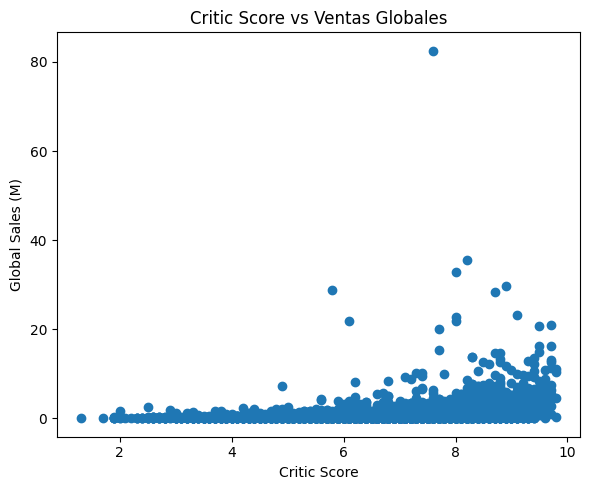

TypeError: float() argument must be a string or a real number, not 'NAType'

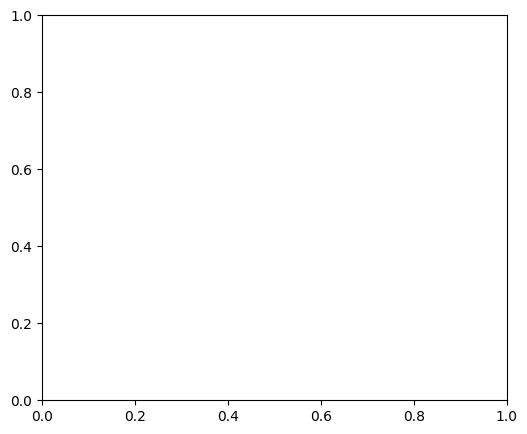

In [38]:
if 'df_clean' in globals() and set(["critic_score","user_score","global_sales"]).issubset(df_clean.columns):
    # Correlaciones numéricas
    num_cols = df_clean.select_dtypes(include=[np.number]).columns
    corr = df_clean[num_cols].corr()
    display(corr)

    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.title("Matriz de correlación (numérica)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Relación puntuaciones vs ventas
    plt.figure(figsize=(6,5))
    plt.scatter(df_clean["critic_score"], df_clean["global_sales"])
    plt.xlabel("Critic Score")
    plt.ylabel("Global Sales (M)")
    plt.title("Critic Score vs Ventas Globales")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    plt.scatter(df_clean["user_score"], df_clean["global_sales"])
    plt.xlabel("User Score")
    plt.ylabel("Global Sales (M)")
    plt.title("User Score vs Ventas Globales")
    plt.tight_layout()
    plt.show()

In [ ]:
if 'df_clean' in globals() and set(["na_sales","eu_sales","jp_sales","other_sales"]).issubset(df_clean.columns):
    region_cols = ["na_sales","eu_sales","jp_sales","other_sales"]
    region_totals = df_clean[region_cols].sum().sort_values(ascending=False)
    display(region_totals)

    plt.figure(figsize=(7,5))
    region_totals.plot(kind='bar')
    plt.title("Ventas totales por región (M de copias)")
    plt.xlabel("Región")
    plt.ylabel("Ventas (millones)")
    plt.tight_layout()
    plt.show()

## 5) Guardado de dataset limpio

In [ ]:
if 'df_clean' in globals():
    out_path = Path("/mnt/data/video_game_sales_clean.csv")
    df_clean.to_csv(out_path, index=False)
    print("✅ Dataset limpio guardado en:", out_path)

## 6) (Opcional) Generar Informe Ejecutivo automático

In [ ]:
# Este bloque genera un informe ejecutivo simple basado en agregaciones clave.
# Ejecuta esto después de haber corrido todo el EDA.
from pathlib import Path

if 'df_clean' in globals():
    lines = []
    lines.append("# Informe Ejecutivo — Video Game Sales")
    lines.append("")

    # Rango temporal
    if "year" in df_clean.columns:
        years = df_clean['year'].dropna().astype(int)
        if not years.empty:
            lines.append(f"- Cobertura temporal aproximada: {years.min()}–{years.max()}.")

    # Top plataforma
    if set(['platform','global_sales']).issubset(df_clean.columns):
        top_plat = df_clean.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head(5)
        lines.append("")
        lines.append("**Top plataformas por ventas globales:**")
        for k,v in top_plat.items():
            lines.append(f"- {k}: {v:.1f} M")

    # Top género
    if set(['genre','global_sales']).issubset(df_clean.columns):
        top_genre = df_clean.groupby('genre')['global_sales'].sum().sort_values(ascending=False).head(5)
        lines.append("")
        lines.append("**Top géneros por ventas globales:**")
        for k,v in top_genre.items():
            lines.append(f"- {k}: {v:.1f} M")

    # Región
    region_cols = ["na_sales","eu_sales","jp_sales","other_sales"]
    if set(region_cols).issubset(df_clean.columns):
        totals = df_clean[region_cols].sum()
        tot = totals.sum()
        if tot > 0:
            lines.append("")
            lines.append("**Distribución regional estimada:**")
            for c in region_cols:
                share = (totals[c]/tot)*100 if tot > 0 else 0
                lines.append(f"- {c.upper()}: {share:.1f}%")

    # Correlaciones
    num_cols = df_clean.select_dtypes(include=[np.number]).columns
    if len(num_cols)>0:
        corr = df_clean[num_cols].corr()
        # destacar relación con ventas
        if "global_sales" in corr.columns:
            cs = corr["global_sales"].drop("global_sales", errors="ignore").sort_values(ascending=False)
            lines.append("")
            lines.append("**Variables con mayor asociación (lineal) con ventas globales:**")
            for k,v in cs.head(5).items():
                lines.append(f"- {k}: corr={v:.2f}")

    report_path = Path("/mnt/data/executive_summary.md")
    report_path.write_text("\n".join(lines), encoding="utf-8")
    print("✅ Informe ejecutivo creado:", report_path)
else:
    print("Primero genera df_clean en pasos anteriores.")

Primero genera df_clean en pasos anteriores.
